# Project 2 Data Wrangling and EDA

Data in the real world is messy. Dealing with messy data sets is painful and burns through time which could be spent analysing the data itself.

This dataset contains historic work order text data for different divisions.  The data is generated using queries in a relational database and exported as csv files.  Some data are scrambled.  

USPS Suffix data is fromhttps://pe.usps.com/text/pub28/28apc_002.htm

In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter 

import re
import ftfy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [395]:
def cleanse_str(string): 
    string = ftfy.fix_text(string) # fix text encoding issues
    string = string.encode("ascii", errors="ignore").decode() #remove non ascii chars
    string = string.lower() #make lower case
    chars_to_remove = ["#", "@", ")","(",".","|","[","]","{","}","'"]
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
    string = re.sub(rx, '', string) #remove the list of chars defined above
    string = string.replace('&', 'and')
    string = string.replace(',', ' ')
    string = string.replace('`', ' ')
    #string = string.replace('unknown', ' ')
    string = string.replace('-', ' ')
    string = string.replace('+', ' and ')
    #string = string.title() # normalise case - capital at start of each word
    string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single space
    string = ' '+ string +' ' # pad names for ngrams...
    string = re.sub(r'[,-./]|\sBD',r'', string)

    return string

In [396]:
def cleanse_addr_suffix (string): 
    
    string = re.sub(r'[0-9]+', '', string)
    
    return string

In [397]:
def standardize_addr_suffix (string):
    
    string = string + ' '
    
    #string = cleanse_addr_suffix(string)
    
    string = re.sub(' aly ', ' alley ', string)
    string = re.sub(' annex ', ' anex ', string)
    string = re.sub(' anx ', ' anex ', string)
    string = re.sub(' ave ', ' avenue ', string)
    string = re.sub(' av ', ' avenue ', string)
    string = re.sub(' aven ', ' avenue ', string)
    string = re.sub(' bch ', ' beach ', string)
    string = re.sub(' bnd ', ' bend ', string)
    string = re.sub(' blf ', ' bluff ', string)
    string = re.sub(' btm ', ' bottom ', string)
    string = re.sub(' blvd ', ' boulevard ', string)
    string = re.sub(' br ', ' branch ', string)
    string = re.sub(' brg ', ' bridge ', string)
    string = re.sub(' brk ', ' brook ', string)
    string = re.sub(' byp ', ' bypass ', string)
    string = re.sub(' bypas ', ' bypass ', string)
    string = re.sub(' cp ', ' camp ', string)
    string = re.sub(' cent ', ' center ', string)
    string = re.sub(' centre ', ' center ', string)
    string = re.sub(' cntr ', ' center ', string)
    string = re.sub(' centr ', ' center ', string)
    string = re.sub(' ctr ', ' center ', string)
    string = re.sub(' circl ', ' circle ', string)
    string = re.sub(' cir ', ' circle ', string)
    string = re.sub(' cor ', ' corner ', string)
    string = re.sub(' cors ', ' corners ', string)
    string = re.sub(' crse ', ' course ', string)
    string = re.sub(' ct ', ' court ', string)
    string = re.sub(' cts ', ' courts ', string)
    string = re.sub(' cv ', ' cove ', string)
    string = re.sub(' crk ', ' creek ', string)
    string = re.sub(' cres ', ' crescent ', string)
    string = re.sub(' div ', ' divide ', string)
    string = re.sub(' dr ', ' drive ', string)
    string = re.sub(' drv ', ' drive ', string)
    string = re.sub(' drives ', ' drives  ', string)
    string = re.sub(' est ', ' estate ', string)
    string = re.sub(' ests ', ' estates ', string)
    string = re.sub(' express ', ' expressway ', string)
    string = re.sub(' ext ', ' extension ', string)
    string = re.sub(' fry ', ' ferry ', string)
    string = re.sub(' fld ', ' field ', string)
    string = re.sub(' frd ', ' ford ', string)
    string = re.sub(' frst ', ' forest ', string)
    string = re.sub(' forg ', ' forge ', string)
    string = re.sub(' frk ', ' fork ', string)
    string = re.sub(' ft ', ' fort ', string)
    string = re.sub(' gdns ', ' gardens ', string)
    string = re.sub(' grdns ', ' gardens ', string)
    string = re.sub(' gatewy ', ' gateway ', string)
    string = re.sub(' gln ', ' glen ', string)
    string = re.sub(' grn ', ' green ', string)
    string = re.sub(' grov ', ' grove ', string)
    string = re.sub(' grv ', ' grove ', string)
    string = re.sub(' harbr ', ' harbor ', string)
    string = re.sub(' hvn ', ' haven ', string)
    string = re.sub(' hts ', ' heights ', string)
    string = re.sub(' ht ', ' heights ', string)
    string = re.sub(' hwy ', ' highway ', string)
    string = re.sub(' hway ', ' highway ', string)
    string = re.sub(' hiway ', ' highway ', string)
    string = re.sub(' hl ', ' hill ', string)
    string = re.sub(' hls ', ' hills ', string)
    string = re.sub(' holw ', ' hollow ', string)
    string = re.sub(' is ', ' island ', string)
    string = re.sub(' jct ', ' junction ', string)
    string = re.sub(' knl ', ' knoll ', string)
    string = re.sub(' knls ', ' knolls ', string)
    string = re.sub(' lk ', ' lake ', string)
    string = re.sub(' lks ', ' lakes ', string)
    string = re.sub(' lndg ', ' landing ', string)
    string = re.sub(' ln ', ' lane ', string)
    string = re.sub(' lf ', ' loaf ', string)
    string = re.sub(' lodg ', ' lodge ', string)
    string = re.sub(' ldg ', ' lodge ', string)
    string = re.sub(' mnr ', ' manor ', string)
    string = re.sub(' mdw ', ' meadows ', string)
    string = re.sub(' mdws ', ' meadows ', string)
    string = re.sub(' mnt ', ' mount ', string)
    string = re.sub(' mt ', ' mount ', string)
    string = re.sub(' mtn ', ' mountain ', string)
    string = re.sub(' orch ', ' orchard ', string)
    string = re.sub(' prk ', ' park ', string)
    string = re.sub(' pky ', ' parkway ', string)
    string = re.sub(' pkwy ', ' parkway ', string)
    string = re.sub(' pl ', ' place ', string)
    string = re.sub(' pln ', ' plain ', string)
    string = re.sub(' plns ', ' plains ', string)
    string = re.sub(' plz ', ' plaza ', string)
    string = re.sub(' pt ', ' point ', string)
    string = re.sub(' pts ', ' points ', string)
    string = re.sub(' pr ', ' prairie ', string)
    string = re.sub(' rst ', ' rest ', string)
    string = re.sub(' rdge ', ' ridge ', string)
    string = re.sub(' rdg ', ' ridge ', string)
    string = re.sub(' rvr ', ' river ', string)
    string = re.sub(' rd ', ' road ', string)
    string = re.sub(' rds ', ' roads ', string)
    string = re.sub(' shr ', ' shore ', string)
    string = re.sub(' spg ', ' spring ', string)
    string = re.sub(' spgs ', ' springs ', string)
    string = re.sub(' sq ', ' square ', string)
    string = re.sub(' stn ', ' station ', string)
    string = re.sub(' sta ', ' station ', string)
    string = re.sub(' str ', ' street ', string)
    string = re.sub(' st ', ' street ', string)
    string = re.sub(' ter ', ' terrace ', string)
    string = re.sub(' terr ', ' terrace ', string)
    string = re.sub(' trce ', ' trace ', string)
    string = re.sub(' tracks ', ' track ', string)
    string = re.sub(' trak ', ' track ', string)
    string = re.sub(' trails ', ' trail ', string)
    string = re.sub(' trl ', ' trail ', string)
    string = re.sub(' trlr ', ' trailer ', string)
    string = re.sub(' un ', ' union ', string)
    string = re.sub(' vly ', ' valley ', string)
    string = re.sub(' vally ', ' valley ', string)
    string = re.sub(' vw ', ' view ', string)
    string = re.sub(' villiage ', ' village ', string)
    string = re.sub(' vill ', ' village ', string)
    string = re.sub(' vlg ', ' village ', string)
    string = re.sub(' vl ', ' ville ', string)
    string = re.sub(' vis ', ' vista ', string)
    string = re.sub(' wy ', ' way ', string)


    return string

In [398]:
def get_word_list (list_of_string):
    split_words = []
    
    for value in list_of_string:#.iteritems():
        split_word = value.split()
        split_words.extend(split_word)
        
    return split_words

In [399]:
# load data
file_path = 'local_directory' # mask this path.  

df4_g=pd.read_csv(file_path + 'p_addr_list.csv',encoding='ISO-8859-1')

df_match = pd.read_csv(file_path + 'addr_match.csv')
df_exception = pd.read_csv(file_path + 'addr_exception.csv')

df_raw_sum = pd.read_csv(file_path + 'addr_raw_sum.csv')
df_match_1_n = pd.read_csv(file_path + 'addr_match_1_n.csv')

In [400]:
df_master = pd.read_csv(file_path + 'addr_master.csv')

In [401]:
df_usps_suffix = df=pd.read_csv(file_path + 'usps_suffix.csv')

In [402]:
#df=pd.read_csv(file_path + 'Sample_Data_WOAddr_messy.csv')

In [403]:
#df['addr1'].fillna(df['city1'], inplace=True)
#df['addr_cln']= df['addr1'].apply(cleanse_str)#.str.lower()
#df['addr_cln'].str.upper()
#df.dropna(inplace=True)
#df['addr_c'] = df['addr1'].apply(cleanse_str)
#df['addr_s'] = df['addr_c'].apply(cleanse_addr_suffix)

In [404]:
#df['addr_s'] = df['addr_c'].apply(standardize_addr_suffix)

In [405]:
#df

In [406]:
df_usps_suffix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 3 columns):
Primary_Suffix    515 non-null object
Comm_suffix       515 non-null object
Std_suffix        515 non-null object
dtypes: object(3)
memory usage: 12.1+ KB


In [407]:
df_usps_suffix['Primary_Suffix'] = df_usps_suffix['Primary_Suffix'].str.lower()
df_usps_suffix['Comm_suffix'] = df_usps_suffix['Comm_suffix'].str.lower()
df_usps_suffix['Std_suffix'] = df_usps_suffix['Std_suffix'].str.lower()

In [408]:
df_usps_suffix.head()

,Primary_Suffix,Comm_suffix,Std_suffix
0,alley,allee,aly
1,alley,alley,aly
2,alley,ally,aly
3,alley,aly,aly
4,anex,anex,anx


In [409]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505767 entries, 0 to 505766
Data columns (total 3 columns):
P_DIV_CD    505767 non-null object
P_ADDR      505761 non-null object
P_CITY      505767 non-null object
dtypes: object(3)
memory usage: 11.6+ MB


In [410]:
df_master.dropna(inplace=True)

In [411]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505761 entries, 0 to 505766
Data columns (total 3 columns):
P_DIV_CD    505761 non-null object
P_ADDR      505761 non-null object
P_CITY      505761 non-null object
dtypes: object(3)
memory usage: 15.4+ MB


In [412]:
df_exception.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530437 entries, 0 to 530436
Data columns (total 6 columns):
DATAID         530437 non-null object
M_TXT          530437 non-null object
M_DIV_CD       530437 non-null object
M_ADDR         526190 non-null object
M_CITY         530320 non-null object
M_ADDR_TYPE    530401 non-null object
dtypes: object(6)
memory usage: 24.3+ MB


In [413]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
DATAID         30000 non-null int64
M_TXT          30000 non-null object
M_DIV_CD       30000 non-null object
M_ADDR         30000 non-null object
M_CITY         30000 non-null object
M_ADDR_TYPE    30000 non-null object
P_ID           30000 non-null int64
P_ADDR         30000 non-null object
P_CITY         30000 non-null object
MATCHCODE      30000 non-null object
dtypes: int64(2), object(8)
memory usage: 2.3+ MB


In [414]:
df_exception.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530437 entries, 0 to 530436
Data columns (total 6 columns):
DATAID         530437 non-null object
M_TXT          530437 non-null object
M_DIV_CD       530437 non-null object
M_ADDR         526190 non-null object
M_CITY         530320 non-null object
M_ADDR_TYPE    530401 non-null object
dtypes: object(6)
memory usage: 24.3+ MB


In [415]:
# handle NULL fields
df_exception['M_ADDR'].fillna(df_exception['M_TXT'], inplace=True)
df_exception['M_ADDR_TYPE'].fillna('Unknown', inplace=True)
df_exception['M_CITY'].fillna('Unknown', inplace=True)

In [416]:
df_exception.M_ADDR_TYPE.unique()

array(['SIMPLE', 'LOT', 'ROUTE', 'RANGE', 'NOTDEFINED', 'BLOCK', 'BLANK',
       'MULTI', 'Unknown'], dtype=object)

In [417]:
# cleanse text
print('Start text cleansing ...')
t1 = time.time()

df_match['M_ADDR_c'] = df_match['M_ADDR'].apply(cleanse_str)
df_match['P_ADDR_c'] = df_match['P_ADDR'].apply(cleanse_str)
df_match['M_TXT_c'] = df_match['M_TXT'].apply(cleanse_str)
df_exception['M_ADDR_c'] = df_exception['M_ADDR'].apply(cleanse_str)
df_exception['M_TXT_c'] = df_exception['M_TXT'].apply(cleanse_str)

df_match['M_CITY'] = df_match['M_CITY'].str.lower()
df_match['P_CITY'] = df_match['P_CITY'].str.lower()
df_exception['M_CITY'] = df_exception['M_CITY'].str.lower()

t = time.time() - t1
print("SELFTIMED:", t)

Start text cleansing ...
SELFTIMED: 48.190377950668335


In [418]:
print('Start text cleansing ...')
time1 = time.time()

df_master['P_ADDR_c'] = df_master['P_ADDR'].apply(cleanse_str)
df_master['P_CITY_c'] = df_master['P_CITY'].apply(cleanse_str)

t = time.time() - t1
print("SELFTIMED:", t)

Start text cleansing ...
SELFTIMED: 81.92391037940979


In [419]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505761 entries, 0 to 505766
Data columns (total 5 columns):
P_DIV_CD    505761 non-null object
P_ADDR      505761 non-null object
P_CITY      505761 non-null object
P_ADDR_c    505761 non-null object
P_CITY_c    505761 non-null object
dtypes: object(5)
memory usage: 23.2+ MB


In [420]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
DATAID         30000 non-null int64
M_TXT          30000 non-null object
M_DIV_CD       30000 non-null object
M_ADDR         30000 non-null object
M_CITY         30000 non-null object
M_ADDR_TYPE    30000 non-null object
P_ID           30000 non-null int64
P_ADDR         30000 non-null object
P_CITY         30000 non-null object
MATCHCODE      30000 non-null object
M_ADDR_c       30000 non-null object
P_ADDR_c       30000 non-null object
M_TXT_c        30000 non-null object
dtypes: int64(2), object(11)
memory usage: 3.0+ MB


In [421]:
df_exception.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530437 entries, 0 to 530436
Data columns (total 8 columns):
DATAID         530437 non-null object
M_TXT          530437 non-null object
M_DIV_CD       530437 non-null object
M_ADDR         530437 non-null object
M_CITY         530437 non-null object
M_ADDR_TYPE    530437 non-null object
M_ADDR_c       530437 non-null object
M_TXT_c        530437 non-null object
dtypes: object(8)
memory usage: 32.4+ MB


In [422]:
df_exception_s= df_exception[df_exception.M_ADDR_TYPE=='SIMPLE']
df_exception_s[df_exception.M_DIV_CD=='d6'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12166 entries, 8649 to 530435
Data columns (total 8 columns):
DATAID         12166 non-null object
M_TXT          12166 non-null object
M_DIV_CD       12166 non-null object
M_ADDR         12166 non-null object
M_CITY         12166 non-null object
M_ADDR_TYPE    12166 non-null object
M_ADDR_c       12166 non-null object
M_TXT_c        12166 non-null object
dtypes: object(8)
memory usage: 855.4+ KB


C:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## EDA

### Analyze address suffix frenquency and format 

Will use collection Counter to count possible suffix used by address data sets

In [424]:
# find the most frenqucent words - find out address suffix
from collections import Counter 

print('start ...')

t1=time.time()

df_list_m= df_match['M_ADDR_c']#.apply(cleanse_addr_suffix)

t = time.time() - t1
print('Removed number from string.  Time used ', t)
  
# split() returns list of all the words in the string 
split_it_m = get_word_list(df_list_m)
  
t = time.time() - t1
print('Split into words.  Time used ', t)

# Pass the split_it list to instance of Counter class. 
Counter_m = Counter(split_it_m) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur_m = Counter_m.most_common(50) 
  
print(most_occur_m) 

t = time.time() - t1
print('Completed in ', t)

start ...
Removed number from string.  Time used  0.0060176849365234375
Split into words.  Time used  0.031081199645996094
[('ave', 6293), ('st', 6234), ('dr', 4474), ('rd', 3465), ('n', 2832), ('s', 2646), ('ln', 1492), ('ct', 1193), ('cir', 1109), ('sw', 1098), ('pl', 984), ('w', 902), ('av', 660), ('way', 548), ('e', 490), ('4th', 481), ('ridge', 379), ('1st', 374), ('2nd', 374), ('3rd', 369), ('blvd', 362), ('hwy', 358), ('park', 319), ('6th', 319), ('5th', 317), ('7th', 294), ('lake', 292), ('valley', 285), ('10th', 283), ('9th', 244), ('crest', 236), ('8th', 232), ('15th', 229), ('pkwy', 221), ('ter', 213), ('12th', 211), ('11th', 208), ('16th', 205), ('hill', 204), ('19th', 198), ('oak', 192), ('highland', 188), ('trl', 179), ('old', 178), ('18th', 178), ('14th', 177), ('20th', 163), ('13th', 160), ('creek', 150), ('17th', 149)]
Completed in  0.07621622085571289


In [425]:
# find the most frenqucent words - find out address suffix
from collections import Counter 

print('start ...')

t1=time.time()

df_list1 = df_exception['M_ADDR_c']#.apply(cleanse_addr_suffix)

t = time.time() - t1
print('Removed number from string.  Time used ', t)
  
# split() returns list of all the words in the string 
split_it1 = get_word_list(df_list1)
  
t = time.time() - t1
print('Split into words.  Time used ', t)

# Pass the split_it list to instance of Counter class. 
Counter1 = Counter(split_it1) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur1 = Counter1.most_common(50) 
  
print(most_occur1) 

t = time.time() - t1
print('Completed in ', t)

start ...
Removed number from string.  Time used  0.0
Split into words.  Time used  0.5182955265045166
[('st', 142748), ('ave', 119192), ('n', 67851), ('rd', 63447), ('dr', 46065), ('s', 46044), ('0000', 18904), ('hwy', 17271), ('w', 15022), ('e', 14507), ('ln', 13299), ('ct', 12405), ('cir', 11959), ('pl', 11433), ('av', 10411), ('rte', 8776), ('1st', 8229), ('sw', 7893), ('2nd', 6952), ('3rd', 6920), ('5th', 6784), ('none', 6778), ('6th', 6525), ('4th', 6523), ('10th', 6116), ('ens', 5557), ('8th', 5545), ('1', 5490), ('7th', 5232), ('blvd', 5192), ('old', 5034), ('valley', 4884), ('9th', 4711), ('19th', 4445), ('ridge', 4260), ('11th', 4259), ('2', 4150), ('18th', 4098), ('rt', 4040), ('way', 4000), ('15th', 3956), ('12th', 3947), ('and', 3933), ('20th', 3857), ('16th', 3801), ('park', 3764), ('14th', 3627), ('hill', 3607), ('13th', 3410), ('24th', 3278)]
Completed in  0.8224079608917236


In [426]:
# find the most frenqucent words - find out address suffix
from collections import Counter 

print('start ...')

t1=time.time()

df_list2= df_master['P_ADDR_c']#.apply(cleanse_addr_suffix)

t = time.time() - t1
print('Removed number from string.  Time used ', t)
  
# split() returns list of all the words in the string 
split_it2 = get_word_list(df_list2)
  
t = time.time() - t1
print('Split into words.  Time used ', t)

# Pass the split_it list to instance of Counter class. 
Counter2 = Counter(split_it2) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur2 = Counter2.most_common(50) 
  
print(most_occur2) 

t = time.time() - t1
print('Completed in ', t)

start ...
Removed number from string.  Time used  0.12936019897460938
Split into words.  Time used  0.5313823223114014
[('dr', 99313), ('st', 90268), ('ave', 77373), ('rd', 66040), ('ln', 32483), ('n', 30459), ('cir', 29182), ('s', 27463), ('ct', 20045), ('sw', 15069), ('w', 14048), ('pl', 13371), ('way', 10719), ('e', 8440), ('highway', 7503), ('park', 7399), ('ridge', 6548), ('blvd', 6449), ('pkwy', 5735), ('road', 5459), ('trl', 5317), ('avenue', 5190), ('old', 4835), ('ensley', 4811), ('street', 4735), ('lake', 4725), ('oak', 4664), ('4th', 4471), ('valley', 4159), ('county', 4146), ('3rd', 3829), ('hill', 3698), ('crest', 3657), ('creek', 3600), ('5th', 3585), ('1st', 3549), ('2nd', 3448), ('6th', 3232), ('ter', 3203), ('forest', 2965), ('7th', 2915), ('hwy', 2863), ('9th', 2813), ('brook', 2728), ('loop', 2720), ('10th', 2617), ('pine', 2497), ('highland', 2408), ('8th', 2399), ('trce', 2304)]
Completed in  0.7670149803161621


In [506]:
# convert Counter into Dataframe
df_match_counter = pd.DataFrame.from_dict(Counter_m, orient='index').reset_index()
df_match_counter.columns =  ['Word_Seg', 'cnt']

df_exception_counter = pd.DataFrame.from_dict(Counter1, orient='index').reset_index()
df_exception_counter.columns = ['Word_Seg', 'cnt'] 

df_master_counter = pd.DataFrame.from_dict(Counter2, orient='index').reset_index()
df_master_counter.columns = ['Word_Seg', 'cnt']

In [507]:
df_exception_counter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41439 entries, 0 to 41438
Data columns (total 2 columns):
Word_Seg    41439 non-null object
cnt         41439 non-null int64
dtypes: int64(1), object(1)
memory usage: 647.6+ KB


### Look up by commonly used suffix

Join split words with commonly used suffix variances provided by USPS data set

In [429]:
resultm = pd.merge(df_match_counter, df_usps_suffix, how='inner', left_on='Word_Seg', right_on='Comm_suffix')
result1 = pd.merge(df_exception_counter, df_usps_suffix, how='inner', left_on='Word_Seg', right_on='Comm_suffix')
result2 = pd.merge(df_master_counter, df_usps_suffix, how='inner', left_on='Word_Seg', right_on='Comm_suffix')

In [430]:
result2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 0 to 213
Data columns (total 5 columns):
Word_Seg          214 non-null object
cnt               214 non-null int64
Primary_Suffix    214 non-null object
Comm_suffix       214 non-null object
Std_suffix        214 non-null object
dtypes: int64(1), object(4)
memory usage: 10.0+ KB


In [431]:
resultm.to_csv(file_path + 'suffix_resultm.csv')
result1.to_csv(file_path + 'suffix_result1.csv')
result2.to_csv(file_path + 'suffix_result2.csv')

In [432]:
len(result1.Word_Seg.unique()), len(result2.Word_Seg.unique())#head()

(260, 214)

In [433]:
result2[result2.Primary_Suffix=='place']

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
6,pl,13371,place,pl,pl
118,place,545,place,place,pl


In [508]:
# get top 50 suffix used by address data sets
top50_rm = resultm.sort_values(['cnt'], ascending=False).head(50)
top50_r1 = result1.sort_values(['cnt'], ascending=False).head(50)
top50_r2 = result2.sort_values(['cnt'], ascending=False).head(50)

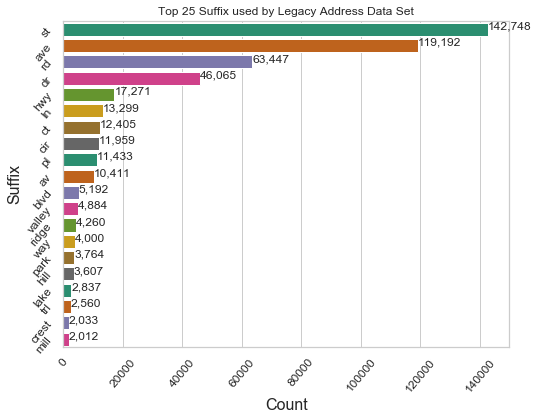

In [509]:
# plot1 real 
N = 5
ind = np.arange(N)
width = 0.35

fig, ax= plt.subplots(figsize =(8,6))
sns.set_style('whitegrid')
sns.set_context('notebook')
#sns.set(font_scale=2)
plt.fontsize =(35)

ax=sns.barplot( palette="Dark2", ax=ax, x='cnt', y='Word_Seg', data=top50_r1.head(20))

for p in ax.patches:
    percentage ='{:,.0f}'.format(p.get_width())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))
    
#ax1=sns.barplot( palette="Dark2", ax=ax, x='Matched_Total', y='DIV_CD', data=df_stat_by_div)

    
plt.xticks(rotation =50,fontsize =12)
plt.yticks(rotation =50,fontsize =12)

plt.title('Top 25 Suffix used by Legacy Address Data Set',
         fontsize =12 
         )
plt.xlabel ('Count',fontsize = 16)
plt.ylabel ('Suffix',fontsize = 16)

plt.show ()

In [510]:
# one example shows that for 'center' , there are six variances 
df_m_suffix[df_m_suffix.Primary_Suffix=='center']

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
170,cntr,7,center,cntr,ctr
120,centre,14,center,centre,ctr
228,centr,1,center,centr,ctr
83,ctr,338,center,ctr,ctr
42,center,933,center,center,ctr
146,cent,94,center,cent,ctr


In [512]:
# generate matrix for top 10 primary suffix which have multiple variances in legacy address data set
include = list(result1.groupby("Primary_Suffix").Word_Seg.count().sort_values(ascending=False).head(10).index)
df_m_suffix = result1.query('Primary_Suffix in @include').sort_values(['Primary_Suffix'], ascending=True)
df_m_suffix.groupby(['Primary_Suffix','Word_Seg']).size().unstack(fill_value=0)

Word_Seg,av,ave,aven,avenue,cent,center,centr,centre,cir,circl,...,ridge,st,sta,station,stn,str,street,ter,terr,terrace
Primary_Suffix,,,,,,,,,,,,,,,,,,,,,
avenue,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
center,0,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
circle,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
drive,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
heights,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
highway,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ridge,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
station,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
street,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0


### Conslidate address suffix variances into USPS Primary Suffix 

In [439]:
# standardize address suffix

print('Start text cleansing ...')
time1 = time.time()

df_match['M_ADDR_s'] = df_match['M_ADDR_c'].apply(standardize_addr_suffix)
df_match['P_ADDR_s'] = df_match['P_ADDR_c'].apply(standardize_addr_suffix)
df_match['M_TXT_s'] = df_match['M_TXT_c'].apply(standardize_addr_suffix)
df_exception['M_ADDR_s'] = df_exception['M_ADDR_c'].apply(standardize_addr_suffix)
df_exception['M_TXT_s'] = df_exception['M_TXT_c'].apply(standardize_addr_suffix)

df_master['P_ADDR_s'] = df_master['P_ADDR_c'].apply(standardize_addr_suffix)

t = time.time() - t1
print("SELFTIMED:", t)

Start text cleansing ...
SELFTIMED: 264.58072328567505


In [515]:
df_match[['M_ADDR_c','M_ADDR_s']].head(1)

,M_ADDR_c,M_ADDR_s
0,3107 dartmouth ave,3107 dartmouth avenue


### Verify the result of standardized primary suffix 

In [441]:
# find the most frenqucent words - find out address suffix
from collections import Counter 

print('start ...')

t1=time.time()

df_list1s = df_exception['M_ADDR_s']#.apply(cleanse_addr_suffix)

t = time.time() - t1
print('Removed number from string.  Time used ', t)
  
# split() returns list of all the words in the string 
split_it1s = get_word_list(df_list1s)
  
t = time.time() - t1
print('Split into words.  Time used ', t)

# Pass the split_it list to instance of Counter class. 
Counter1s = Counter(split_it1s) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur1s = Counter1s.most_common(50) 
  
print(most_occur1s) 

t = time.time() - t1
print('Completed in ', t)

start ...
Removed number from string.  Time used  0.19252777099609375
Split into words.  Time used  0.68994140625
[('street', 143023), ('avenue', 129808), ('n', 67851), ('road', 64112), ('drive', 46466), ('s', 46044), ('0000', 18904), ('highway', 17380), ('w', 15022), ('e', 14507), ('lane', 14309), ('court', 13364), ('circle', 12532), ('place', 11735), ('rte', 8776), ('1st', 8229), ('sw', 7893), ('2nd', 6952), ('3rd', 6920), ('5th', 6784), ('none', 6778), ('6th', 6525), ('4th', 6523), ('10th', 6116), ('ens', 5557), ('8th', 5545), ('1', 5490), ('7th', 5232), ('boulevard', 5197), ('old', 5034), ('valley', 4931), ('9th', 4711), ('19th', 4445), ('park', 4358), ('ridge', 4322), ('11th', 4259), ('2', 4150), ('18th', 4098), ('rt', 4040), ('way', 4021), ('15th', 3956), ('12th', 3947), ('and', 3933), ('20th', 3857), ('16th', 3801), ('hill', 3756), ('14th', 3627), ('lake', 3477), ('13th', 3410), ('24th', 3278)]
Completed in  0.9990241527557373


In [442]:
# find the most frenqucent words - find out address suffix
from collections import Counter 

print('start ...')

t1=time.time()

df_list2s= df_master['P_ADDR_s']#.apply(cleanse_addr_suffix)

t = time.time() - t1
print('Removed number from string.  Time used ', t)
  
# split() returns list of all the words in the string 
split_it2s = get_word_list(df_list2s)
  
t = time.time() - t1
print('Split into words.  Time used ', t)

# Pass the split_it list to instance of Counter class. 
Counter2s = Counter(split_it2s) 
  
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur2s = Counter2s.most_common(50) 
  
print(most_occur2s) 

t = time.time() - t1
print('Completed in ', t)

start ...
Removed number from string.  Time used  0.1190025806427002
Split into words.  Time used  0.5461223125457764
[('drive', 99341), ('street', 95002), ('avenue', 82563), ('road', 71499), ('lane', 33481), ('n', 30459), ('circle', 29543), ('s', 27463), ('court', 21938), ('sw', 15069), ('w', 14048), ('place', 13916), ('way', 10719), ('highway', 10366), ('e', 8440), ('park', 7399), ('ridge', 7384), ('boulevard', 6473), ('parkway', 6211), ('trail', 5455), ('old', 4835), ('ensley', 4811), ('lake', 4735), ('oak', 4664), ('4th', 4471), ('valley', 4169), ('county', 4146), ('terrace', 4038), ('3rd', 3829), ('hill', 3821), ('crest', 3657), ('creek', 3629), ('5th', 3585), ('1st', 3549), ('2nd', 3448), ('6th', 3232), ('cove', 3230), ('trace', 3167), ('forest', 2967), ('7th', 2915), ('9th', 2813), ('brook', 2753), ('loop', 2720), ('10th', 2617), ('pine', 2497), ('highland', 2408), ('8th', 2399), ('view', 2348), ('lee', 2288), ('11th', 2267)]
Completed in  0.776343822479248


In [443]:
df_exception_counter_s = pd.DataFrame.from_dict(Counter1s, orient='index').reset_index()
df_exception_counter_s.columns = ['Word_Seg', 'cnt'] 
result1s = pd.merge(df_exception_counter_s, df_usps_suffix, how='inner', left_on='Word_Seg', right_on='Comm_suffix')

df_master_counter_s = pd.DataFrame.from_dict(Counter2s, orient='index').reset_index()
df_master_counter_s.columns = ['Word_Seg', 'cnt'] 
result2s = pd.merge(df_master_counter_s, df_usps_suffix, how='inner', left_on='Word_Seg', right_on='Comm_suffix')

In [516]:
result1s.sort_values(['Primary_Suffix'], ascending=True).head()

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
24,alley,2237,alley,alley,aly
146,anex,2,anex,anex,anx
98,arcade,15,arcade,arcade,arc
3,avenue,129808,avenue,avenue,ave
74,beach,330,beach,beach,bch


In [519]:
result1s.sort_values(['cnt'], ascending=False).head()

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
5,street,143023,street,street,st
3,avenue,129808,avenue,avenue,ave
1,road,64112,road,road,rd
8,drive,46466,drive,drive,dr
14,highway,17380,highway,highway,hwy


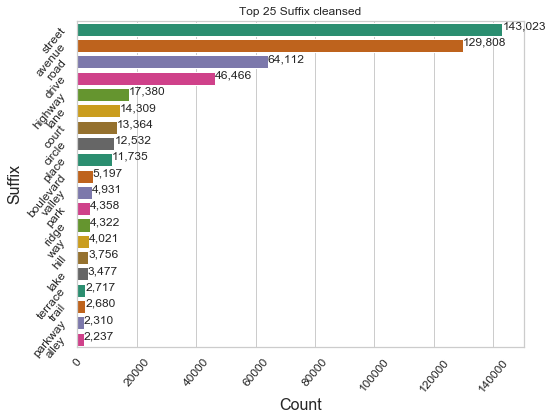

In [446]:
top50_r1s = result1s.sort_values(['cnt'], ascending=False).head(50)

# plot1 real 
N = 5
ind = np.arange(N)
width = 0.35

fig, ax= plt.subplots(figsize =(8,6))
sns.set_style('whitegrid')
sns.set_context('notebook')
#sns.set(font_scale=2)
plt.fontsize =(35)

ax=sns.barplot( palette="Dark2", ax=ax, x='cnt', y='Word_Seg', data=top50_r1s.head(20))

for p in ax.patches:
    percentage ='{:,.0f}'.format(p.get_width())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))
    
#ax1=sns.barplot( palette="Dark2", ax=ax, x='Matched_Total', y='DIV_CD', data=df_stat_by_div)

    
plt.xticks(rotation =50,fontsize =12)
plt.yticks(rotation =50,fontsize =12)

plt.title('Top 25 Suffix cleansed',
         fontsize =12 
         )
plt.xlabel ('Count',fontsize = 16)
plt.ylabel ('Suffix',fontsize = 16)

plt.show ()

In [522]:
# before consolidate suffix
result1[result1.Primary_Suffix=='center']

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
42,center,933,center,center,ctr
83,ctr,338,center,ctr,ctr
120,centre,14,center,centre,ctr
146,cent,94,center,cent,ctr
170,cntr,7,center,cntr,ctr
228,centr,1,center,centr,ctr


In [521]:
# after consolidate suffix
result1s[result1s.Primary_Suffix=='center']

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
41,center,1387,center,center,ctr


#### Exception of suffix consolidation 

Not 100% consolidated.  But te exception is not significant and will not take further efforts

In [524]:
# not perfect.  Still have some excption.  Not significant andwWill ignore as of now
ana_r1s = result1s.groupby('Primary_Suffix').count()
ana_r1s[ana_r1s.Word_Seg> 1]

,Word_Seg,cnt,Comm_suffix,Std_suffix
Primary_Suffix,,,,
drive,2,2,2,2
highway,2,2,2,2
road,2,2,2,2
street,2,2,2,2


In [528]:
# one example: before
result1[result1.Primary_Suffix=='drive']

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
8,dr,46065,drive,dr,dr
111,drive,400,drive,drive,dr
163,drv,3,drive,drv,dr


In [527]:
# after
result1s[result1s.Primary_Suffix=='drive']

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
8,drive,46466,drive,drive,dr
149,dr,2,drive,dr,dr


In [532]:
# data issue
df_exception[df_exception.M_ADDR_s.str.contains('drive dr')][['M_ADDR_c','M_ADDR_s']]

,M_ADDR_c,M_ADDR_s
188620,3809 franklin dr dr,3809 franklin drive dr
530060,107 morgan dr dr,107 morgan drive dr


In [529]:
# before
result1[result1.Primary_Suffix=='street']

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
5,st,142748,street,st,st
74,street,279,street,street,st
246,str,3,street,str,st


In [530]:
# after
result1s[result1s.Primary_Suffix=='street']

,Word_Seg,cnt,Primary_Suffix,Comm_suffix,Std_suffix
5,street,143023,street,street,st
132,st,7,street,st,st


In [526]:
# not perfect.  Still have some excption.  Not significant andwWill ignore as of now
ana_r2s = result2s.groupby('Primary_Suffix').count()
ana_r2s[ana_r2s.Word_Seg> 1]

,Word_Seg,cnt,Comm_suffix,Std_suffix
Primary_Suffix,,,,
street,2,2,2,2


### Next, we will explore the data set.  Used the third party address tool to match the legacy address with address master data set.  We will analyze the matching results as well 

In [457]:
def add_value_labels(ax, spacing=5):

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'

        if y_value < 0:
            space *= -1
            # Vertical alignment
            va = 'top'

        label = "{:}".format(y_value)  # Use :.1f if wanting decimals.

        # Create annotation
        ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va=va)

In [458]:
# exam matched - random sampled
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
DATAID         30000 non-null int64
M_TXT          30000 non-null object
M_DIV_CD       30000 non-null object
M_ADDR         30000 non-null object
M_CITY         30000 non-null object
M_ADDR_TYPE    30000 non-null object
P_ID           30000 non-null int64
P_ADDR         30000 non-null object
P_CITY         30000 non-null object
MATCHCODE      30000 non-null object
M_ADDR_c       30000 non-null object
P_ADDR_c       30000 non-null object
M_TXT_c        30000 non-null object
M_ADDR_s       30000 non-null object
P_ADDR_s       30000 non-null object
M_TXT_s        30000 non-null object
dtypes: int64(2), object(14)
memory usage: 3.7+ MB


In [459]:
df_raw_sum.head()

,DATAID,M_DIV_CD,M_ADDR_TYPE,FOUND_MATCH
0,35137,d2,SIMPLE,N
1,35138,d2,SIMPLE,N
2,35139,d2,SIMPLE,N
3,35140,d2,RANGE,N
4,35141,d2,RANGE,N


In [460]:
df_raw_sum.M_DIV_CD.unique()

array(['d2', 'd3', 'd6', 'd1', 'd7', 'd5', 'd4'], dtype=object)

In [461]:
df_raw_sum[df_raw_sum.FOUND_MATCH=='Y'].head()

,DATAID,M_DIV_CD,M_ADDR_TYPE,FOUND_MATCH
11,35148,d2,SIMPLE,Y
63,35203,d2,SIMPLE,Y
64,35204,d2,SIMPLE,Y
65,35205,d2,SIMPLE,Y
66,35206,d2,SIMPLE,Y


In [462]:
stat = df_raw_sum.groupby('M_DIV_CD').DATAID.count()
df_temp = pd.DataFrame({'DIV_CD':stat.index, 'Raw_Total':stat.values})

stat2 = df_raw_sum[df_raw_sum.FOUND_MATCH=='Y'].groupby('M_DIV_CD').DATAID.count()
df_temp2 = pd.DataFrame({'DIV_CD':stat2.index, 'Matched_Total':stat2.values})

df_stat_by_div = pd.merge(df_temp, df_temp2, on='DIV_CD', how='outer')

In [463]:
stat2

M_DIV_CD
d1     23098
d2    341756
d3     28863
d4     83720
d5     26632
d6     22205
d7     23881
Name: DATAID, dtype: int64

In [464]:
df_stat_by_div

,DIV_CD,Raw_Total,Matched_Total
0,d1,81691,23098
1,d2,622397,341756
2,d3,63682,28863
3,d4,141892,83720
4,d5,49242,26632
5,d6,43782,22205
6,d7,77888,23881


In [465]:
stat = df_raw_sum.groupby('M_ADDR_TYPE').DATAID.count()
df_temp = pd.DataFrame({'TYPE':stat.index, 'Raw_Total':stat.values})

stat2 = df_raw_sum[df_raw_sum.FOUND_MATCH=='Y'].groupby('M_ADDR_TYPE').DATAID.count()
df_temp2 = pd.DataFrame({'TYPE':stat2.index, 'Matched_Total':stat2.values})

df_stat_by_type = pd.merge(df_temp, df_temp2, on='TYPE', how='outer')

In [466]:
df_stat_by_type

,TYPE,Raw_Total,Matched_Total
0,BLANK,69985,6.0
1,BLOCK,2581,NaN
2,LOT,21160,43.0
3,MULTI,3243,1863.0
4,NOTDEFINED,18089,3757.0
5,RANGE,22646,9968.0
6,ROUTE,8995,NaN
7,SIMPLE,933875,534518.0


In [467]:
df_stat_by_type.fillna(0, inplace=True)

In [468]:
df_stat_by_type

,TYPE,Raw_Total,Matched_Total
0,BLANK,69985,6.0
1,BLOCK,2581,0.0
2,LOT,21160,43.0
3,MULTI,3243,1863.0
4,NOTDEFINED,18089,3757.0
5,RANGE,22646,9968.0
6,ROUTE,8995,0.0
7,SIMPLE,933875,534518.0


In [469]:
print (df_raw_sum.groupby(['M_DIV_CD','FOUND_MATCH']).size().unstack(fill_value=0))

FOUND_MATCH       N       Y
M_DIV_CD                   
d1            58593   23098
d2           280641  341756
d3            34819   28863
d4            58172   83720
d5            22610   26632
d6            21577   22205
d7            54007   23881


In [470]:
print (df_raw_sum.groupby(['M_ADDR_TYPE','FOUND_MATCH']).size().unstack(fill_value=0))

FOUND_MATCH       N       Y
M_ADDR_TYPE                
BLANK         69979       6
BLOCK          2581       0
LOT           21117      43
MULTI          1380    1863
NOTDEFINED    14332    3757
RANGE         12678    9968
ROUTE          8995       0
SIMPLE       399357  534518


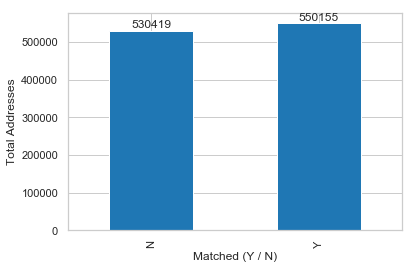

In [471]:
plt.figure(figsize=(6,4))

result_plot = df_raw_sum.groupby(['FOUND_MATCH']).DATAID.count().plot.bar()
plt.xlabel('Matched (Y / N)')
plt.ylabel('Total Addresses')
add_value_labels(result_plot, 1)
plt.show()

### Total 550155 found match but still have 530419 not found the match 

<Figure size 576x432 with 0 Axes>

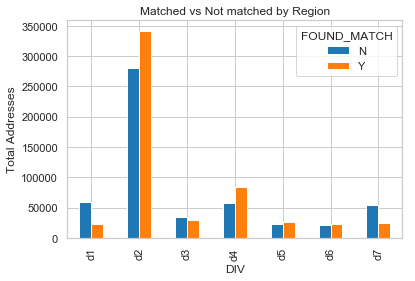

In [472]:
plt.figure(figsize=(8,6))

rsd_plot = df_raw_sum.groupby(['M_DIV_CD','FOUND_MATCH']).size().unstack(fill_value=0).plot.bar()
plt.xlabel('DIV')
plt.ylabel('Total Addresses')
plt.title('Matched vs Not matched by Region')
#add_value_labels(rsd_plot, 1)
plt.show()

### The above plot shows the matched vs not matched within each region 

<Figure size 576x432 with 0 Axes>

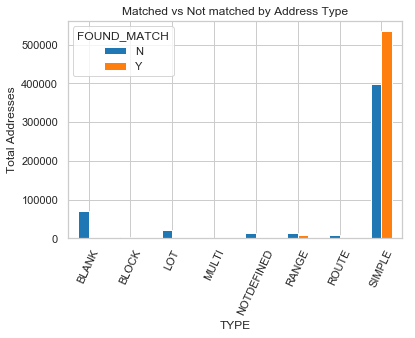

In [473]:
plt.figure(figsize=(8,6))
rst_plot = df_raw_sum.groupby(['M_ADDR_TYPE','FOUND_MATCH']).size().unstack(fill_value=0).plot.bar()
plt.xlabel('TYPE')
plt.ylabel('Total Addresses')
plt.title('Matched vs Not matched by Address Type')
#add_value_labels(rst_plot, 1)
plt.xticks(rotation=65) 
plt.show()

### The above plot shows the matched vs not matched by address type.  Majority addresses have SIMPLE type 

In [474]:
# the maximum addresses one address mapped to the master addresses.  Use this to determine the top_N
df_match_1_n.CNT.max()

32

####  One address was possibly matched to multiple master addresses (i.e., apartment complex).  Use this to determine the top_N

## Fuzzywuzzy functions EDA
Next, will apply these four Fuzzywuzzy fuctions to the sampled data of matched addresses using the third-party address tool.  The confidence level of matching is about 94%.  Then will compare the results and choos the function works best for this data set.

In [478]:
def get_partial_ratio1(row):
    string1 = row['M_ADDR_c']
    string2 = row['P_ADDR_c']
    return fuzz.partial_ratio(string1, string2)

def get_partial_ratio2(row):
    string1 = row['M_TXT_c']
    string2 = row['P_ADDR_c']
    return fuzz.partial_ratio(string1, string2)
'''
df_match['pr1']=df_match.apply(get_partial_ratio1, axis=1)
df_match['pr2']=df_match.apply(get_partial_ratio2, axis=1)
'''

"\ndf_match['pr1']=df_match.apply(get_partial_ratio1, axis=1)\ndf_match['pr2']=df_match.apply(get_partial_ratio2, axis=1)\n"

In [479]:
def get_token_set_ratio1(row):
    string1 = row['M_ADDR_c']
    string2 = row['P_ADDR_c']
    return fuzz.token_set_ratio(string1, string2)

def get_token_set_ratio2(row):
    string1 = row['M_TXT_c']
    string2 = row['P_ADDR_c']
    return fuzz.token_set_ratio(string1, string2)
'''
df_match['tstr1']=df_match.apply(get_token_set_ratio1, axis=1)
df_match['tstr2']=df_match.apply(get_token_set_ratio2, axis=1)
'''

"\ndf_match['tstr1']=df_match.apply(get_token_set_ratio1, axis=1)\ndf_match['tstr2']=df_match.apply(get_token_set_ratio2, axis=1)\n"

In [480]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
DATAID         30000 non-null int64
M_TXT          30000 non-null object
M_DIV_CD       30000 non-null object
M_ADDR         30000 non-null object
M_CITY         30000 non-null object
M_ADDR_TYPE    30000 non-null object
P_ID           30000 non-null int64
P_ADDR         30000 non-null object
P_CITY         30000 non-null object
MATCHCODE      30000 non-null object
M_ADDR_c       30000 non-null object
P_ADDR_c       30000 non-null object
M_TXT_c        30000 non-null object
M_ADDR_s       30000 non-null object
P_ADDR_s       30000 non-null object
M_TXT_s        30000 non-null object
dtypes: int64(2), object(14)
memory usage: 3.7+ MB


In [536]:
# address is cleansed.  Suffix is not consolidated
df_match['r1'] = df_match.apply(lambda row: fuzz.ratio(row['M_ADDR_c'], row['P_ADDR_c']), axis=1)
df_match['pr1'] = df_match.apply(lambda row: fuzz.partial_ratio(row['M_ADDR_c'], row['P_ADDR_c']), axis=1)
df_match['tsr1'] = df_match.apply(lambda row: fuzz.token_sort_ratio(row['M_ADDR_c'], row['P_ADDR_c']), axis=1)
df_match['tstr1'] = df_match.apply(lambda row: fuzz.token_set_ratio(row['M_ADDR_c'], row['P_ADDR_c']), axis=1)

In [487]:
'''
df_match['r2'] = df_match.apply(lambda row: fuzz.ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)
df_match['pr2'] = df_match.apply(lambda row: fuzz.partial_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)
df_match['tsr2'] = df_match.apply(lambda row: fuzz.token_sort_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)
df_match['tstr2'] = df_match.apply(lambda row: fuzz.token_set_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)
'''

"\ndf_match['r2'] = df_match.apply(lambda row: fuzz.ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)\ndf_match['pr2'] = df_match.apply(lambda row: fuzz.partial_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)\ndf_match['tsr2'] = df_match.apply(lambda row: fuzz.token_sort_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)\ndf_match['tstr2'] = df_match.apply(lambda row: fuzz.token_set_ratio(row['M_TXT_c'], row['P_ADDR_c']), axis=1)\n"

In [537]:
# address is cleansed.  Suffix is consolidated to USPS primary suffix
df_match['r1s'] = df_match.apply(lambda row: fuzz.ratio(row['M_ADDR_s'], row['P_ADDR_s']), axis=1)
df_match['pr1s'] = df_match.apply(lambda row: fuzz.partial_ratio(row['M_ADDR_s'], row['P_ADDR_s']), axis=1)
df_match['tsr1s'] = df_match.apply(lambda row: fuzz.token_sort_ratio(row['M_ADDR_s'], row['P_ADDR_s']), axis=1)
df_match['tstr1s'] = df_match.apply(lambda row: fuzz.token_set_ratio(row['M_ADDR_s'], row['P_ADDR_s']), axis=1)

In [540]:
# Fuzzywuzzy ratio matrix
data_to_display=['M_DIV_CD','M_ADDR_TYPE','r1','pr1','tsr1','tstr1','r1s','pr1s','tsr1s','tstr1s']
df_match[df_match.pr1<95][data_to_display].head()

,M_DIV_CD,M_ADDR_TYPE,r1,pr1,tsr1,tstr1,r1s,pr1s,tsr1s,tstr1s
7,d2,SIMPLE,87,84,86,90,81,78,78,82
16,d2,RANGE,88,93,86,100,90,94,88,100
17,d2,SIMPLE,97,94,97,97,98,95,97,97
21,d2,SIMPLE,97,94,97,97,98,95,97,97
24,d2,SIMPLE,89,88,88,88,89,88,88,88


### Calculate percentage of matching with ratio above 90% 

In [541]:
r1_match_pct = len(df_match[df_match.r1 > 90]) / len(df_match)
pr1_match_pct = len(df_match[df_match.pr1 > 90]) / len(df_match)
tsr1_match_pct = len(df_match[df_match.tsr1 > 90]) / len(df_match)
tstr1_match_pct = len(df_match[df_match.tstr1 > 90]) / len(df_match)
print('r1 match (%>90) = ', r1_match_pct)
print('pr1 match (%>90) = ', pr1_match_pct)
print('tsr1 match (%>90) = ', tsr1_match_pct)
print('tstr1 match (%>90) = ', tstr1_match_pct)
print()
r1s_match_pct = len(df_match[df_match.r1s > 90]) / len(df_match)
pr1s_match_pct = len(df_match[df_match.pr1s > 90]) / len(df_match)
tsr1s_match_pct = len(df_match[df_match.tsr1s > 90]) / len(df_match)
tstr1s_match_pct = len(df_match[df_match.tstr1s > 90]) / len(df_match)
print('r1s match (%>90) = ', r1s_match_pct)
print('pr1s match (%>90) = ', pr1s_match_pct)
print('tsr1s match (%>90) = ', tsr1s_match_pct)
print('tstr1s match (%>90) = ', tstr1s_match_pct)
print()

r1 match (%>90) =  0.8581
pr1 match (%>90) =  0.8755
tsr1 match (%>90) =  0.8383666666666667
tstr1 match (%>90) =  0.908

r1s match (%>90) =  0.8698333333333333
pr1s match (%>90) =  0.8921
tsr1s match (%>90) =  0.8601
tstr1s match (%>90) =  0.9305333333333333



#### Compared result s (with ratio>90).  The performance of Fuzywuzzy funtions rank in this order
token_set_raion > partial_ratio > ratio > token_sort_ratio

After consolidated suffix, the ratio of token_set_ratio improved from 90.5% to 93%

In [542]:
r1_mean = df_match['r1'].mean()
pr1_mean = df_match['pr1'].mean()
tsr1_mean = df_match['tsr1'].mean()
tstr1_mean = df_match['tstr1'].mean()
print('r1 mean (%) = ', r1_mean)
print('pr1 mean (%) = ', pr1_mean)
print('tsr1 mean (%) = ', tsr1_mean)
print('tstr1 mean (%) = ', tstr1_mean)
print()
r1s_mean = df_match['r1s'].mean()
pr1s_mean = df_match['pr1s'].mean()
tsr1s_mean = df_match['tsr1s'].mean()
tstr1s_mean = df_match['tstr1s'].mean()
print('r1s mean (%) = ', r1s_mean)
print('pr1s mean (%) = ', pr1s_mean)
print('tsr1s mean (%) = ', tsr1s_mean)
print('tstr1s mean (%) = ', tstr1s_mean)
print()

r1 mean (%) =  96.6229
pr1 mean (%) =  96.90603333333334
tsr1 mean (%) =  96.0952
tstr1 mean (%) =  97.72556666666667

r1s mean (%) =  97.0433
pr1s mean (%) =  97.17993333333334
tsr1s mean (%) =  96.34213333333334
tstr1s mean (%) =  98.1479



### Using boxplot to exam ratio results between 90% and 100%.  

[Text(0, 0, 'Ratio'),
 Text(0, 0, 'Partial Ratio'),
 Text(0, 0, 'Token Sort Ratio'),
 Text(0, 0, 'Token Set Ratio')]

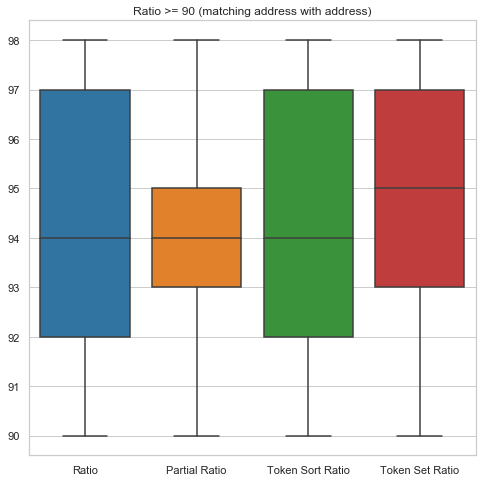

In [492]:
d1=df_match[(df_match.r1>=90) & (df_match.r1<100)].r1
d2=df_match[(df_match.pr1>=90) & (df_match.pr1<100)].pr1
d3=df_match[(df_match.tsr1>=90) & (df_match.tsr1<100)].tsr1
d4=df_match[(df_match.tstr1>=90) & (df_match.tstr1<100)].tstr1

data_to_plot = [d1, d2, d3, d4]
xticklables = ['Ratio', 'Partial Ratio', 'Token Sort Ratio', 'Token Set Ratio']

fig = plt.figure(1, figsize=(8, 8))
plt.title('Ratio >= 90 (matching address with address)') 
ax = sns.boxplot(data = data_to_plot)
ax.set_xticklabels(xticklables)

### Using Histgram to exam results with ratio < 90% 

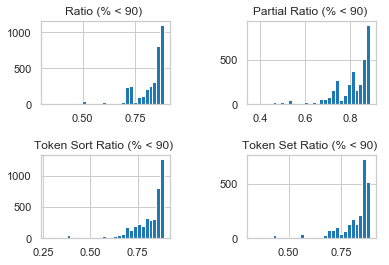

In [493]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)

#ax=fig.add_subplot(2,2,1)
plt.subplot(2,2,1)
_=plt.hist(df_match[df_match.r1< 90].r1/100, bins=30)
plt.title('Ratio (% < 90) ')

plt.subplot(2,2,2)
_=plt.hist(df_match[df_match.pr1< 90].pr1/100, bins=30)
plt.title('Partial Ratio (% < 90) ')
plt.subplot(2,2,3)
_=plt.hist(df_match[df_match.tsr1< 90].tsr1/100, bins=30)
plt.title('Token Sort Ratio (% < 90) ')
plt.subplot(2,2,4)
_=plt.hist(df_match[df_match.tstr1< 90].tstr1/100, bins=30)
plt.title('Token Set Ratio (% < 90) ')
plt.show()

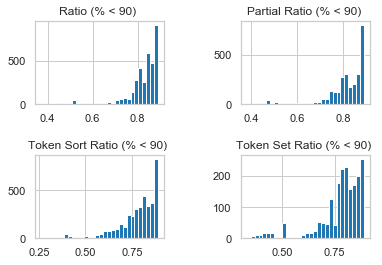

In [494]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)

#ax=fig.add_subplot(2,2,1)
plt.subplot(2,2,1)
_=plt.hist(df_match[df_match.r1s< 90].r1s/100, bins=30)
plt.title('Ratio (% < 90) ')

plt.subplot(2,2,2)
_=plt.hist(df_match[df_match.pr1s< 90].pr1s/100, bins=30)
plt.title('Partial Ratio (% < 90) ')
plt.subplot(2,2,3)
_=plt.hist(df_match[df_match.tsr1s< 90].tsr1s/100, bins=30)
plt.title('Token Sort Ratio (% < 90) ')
plt.subplot(2,2,4)
_=plt.hist(df_match[df_match.tstr1s< 90].tstr1s/100, bins=30)
plt.title('Token Set Ratio (% < 90) ')
plt.show()

### Using boxplot to exam ratio results between 80% and 90%.  

[Text(0, 0, 'Ratio'),
 Text(0, 0, 'Partial Ratio'),
 Text(0, 0, 'Token Sort Ratio'),
 Text(0, 0, 'Token Set Ratio')]

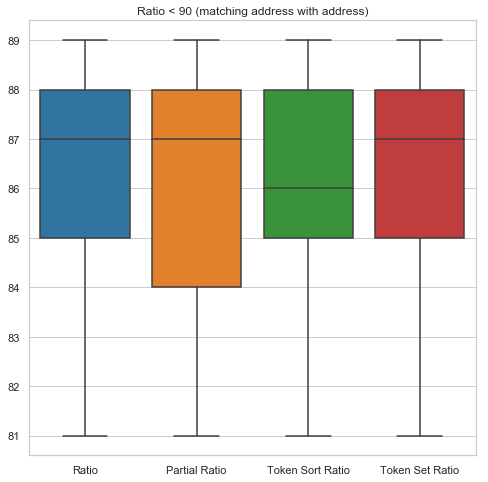

In [545]:
d1=df_match[(df_match.r1>80) & (df_match.r1<90)].r1
d2=df_match[(df_match.pr1>80) & (df_match.pr1<90)].pr1
d3=df_match[(df_match.tsr1>80) & (df_match.tsr1<90)].tsr1
d4=df_match[(df_match.tstr1>80) & (df_match.tstr1<90)].tstr1

data_to_plot = [d1, d2, d3, d4]
xticklables = ['Ratio', 'Partial Ratio', 'Token Sort Ratio', 'Token Set Ratio']

fig = plt.figure(1, figsize=(8, 8))
plt.title('Ratio < 90 (matching address with address)') 
ax = sns.boxplot(data = data_to_plot)
ax.set_xticklabels(xticklables)

[Text(0, 0, 'Ratio'),
 Text(0, 0, 'Partial Ratio'),
 Text(0, 0, 'Token Sort Ratio'),
 Text(0, 0, 'Token Set Ratio')]

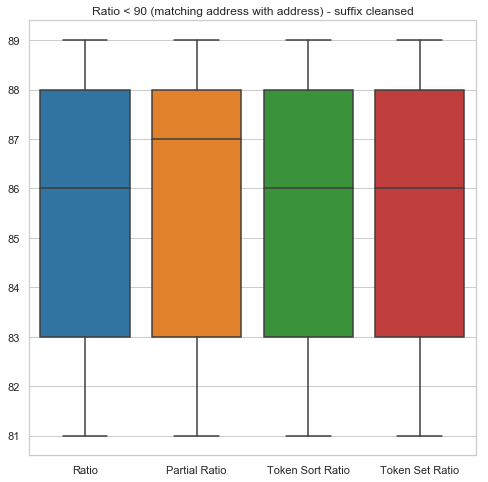

In [544]:
d1=df_match[(df_match.r1s>80) & (df_match.r1s<90)].r1s
d2=df_match[(df_match.pr1s>80) & (df_match.pr1s<90)].pr1s
d3=df_match[(df_match.tsr1s>80) & (df_match.tsr1s<90)].tsr1s
d4=df_match[(df_match.tstr1s>80) & (df_match.tstr1s<90)].tstr1s

data_to_plot = [d1, d2, d3, d4]
xticklables = ['Ratio', 'Partial Ratio', 'Token Sort Ratio', 'Token Set Ratio']

fig = plt.figure(1, figsize=(8, 8))
plt.title('Ratio < 90 (matching address with address) - suffix cleansed') 
ax = sns.boxplot(data = data_to_plot)
ax.set_xticklabels(xticklables)

In [499]:
#df_match[(df_match.pr1>80) & (df_match.pr1<90)].tail()

In [500]:
df_match[(df_match.pr1>90)].M_ADDR_TYPE.unique()

array(['SIMPLE', 'RANGE', 'NOTDEFINED', 'MULTI', 'LOT', 'BLANK'],
      dtype=object)

In [501]:
df_match[(df_match.pr1>90)].groupby('M_ADDR_TYPE').DATAID.count()

M_ADDR_TYPE
BLANK             2
LOT               6
MULTI            93
NOTDEFINED       82
RANGE           577
SIMPLE        25505
Name: DATAID, dtype: int64

In [502]:
df_match[(df_match.pr1s>90)].groupby('M_ADDR_TYPE').DATAID.count()

M_ADDR_TYPE
BLANK             2
LOT               6
MULTI           102
NOTDEFINED      116
RANGE           621
SIMPLE        25916
Name: DATAID, dtype: int64

In [503]:
df_match[(df_match.tstr1>90)].groupby('M_ADDR_TYPE').DATAID.count()

M_ADDR_TYPE
BLANK             2
LOT               5
MULTI            74
NOTDEFINED      191
RANGE           710
SIMPLE        26258
Name: DATAID, dtype: int64

In [504]:
df_match[(df_match.tstr1s>90)].groupby('M_ADDR_TYPE').DATAID.count()

M_ADDR_TYPE
BLANK             2
LOT               6
MULTI            92
NOTDEFINED      203
RANGE           768
SIMPLE        26845
Name: DATAID, dtype: int64